In [1]:
import sys, os
import torch
import numpy as np
import matplotlib

from human_body_prior.tools.omni_tools import copy2cpu as c2c

# Preparing the environment
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline



In [2]:
# Choose the device to run the body model on.
comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from human_body_prior.body_model.body_model import BodyModel

bm_path = './human_body_prior-master/human_body_prior/body_model/smplh/male/model.npz'
dmpl_path ='./human_body_prior-master/human_body_prior/body_model/dmpls/male/model.npz' 

num_betas = 10 # number of body parameters
num_dmpls = 8 # number of DMPL parameters

bm = BodyModel(bm_path=bm_path, num_betas=num_betas, num_dmpls=num_dmpls, path_dmpl=dmpl_path).to(comp_device)
faces = c2c(bm.f)

In [4]:
npz_bdata_path = './human_body_prior-master/human_body_prior/amass_sample.npz' # the path to body data
bdata = np.load(npz_bdata_path)
print('Data keys available:%s'%list(bdata.keys()))
print('Vector poses has %d elements for each of %d frames.'%(bdata['poses'].shape[1], bdata['poses'].shape[0]))
print('Vector dmpls has %d elements for each of %d frames.'%(bdata['dmpls'].shape[1], bdata['dmpls'].shape[0]))
print('Vector trams has %d elements for each of %d frames.'%(bdata['trans'].shape[1], bdata['trans'].shape[0]))
print('Vector betas has %d elements constant for the whole sequence.'%bdata['betas'].shape[0])
print('The subject of the mocap sequence is %s.'%bdata['gender'])

Data keys available:['poses', 'gender', 'mocap_framerate', 'betas', 'marker_data', 'dmpls', 'marker_labels', 'trans']
Vector poses has 156 elements for each of 601 frames.
Vector dmpls has 8 elements for each of 601 frames.
Vector trams has 3 elements for each of 601 frames.
Vector betas has 16 elements constant for the whole sequence.
The subject of the mocap sequence is male.


In [5]:
fId = 0 # frame id of the mocap sequence

root_orient = torch.Tensor(bdata['poses'][fId:fId+1, :3]).to(comp_device) # controls the global root orientation
pose_body = torch.Tensor(bdata['poses'][fId:fId+1, 3:66]).to(comp_device) # controls the body
pose_hand = torch.Tensor(bdata['poses'][fId:fId+1, 66:]).to(comp_device) # controls the finger articulation
betas = torch.Tensor(bdata['betas'][:10][np.newaxis]).to(comp_device) # controls the body shape
dmpls = torch.Tensor(bdata['dmpls'][fId:fId+1]).to(comp_device) # controls soft tissue dynamics

In [7]:
import trimesh
from human_body_prior.tools.omni_tools import colors
from human_body_prior.mesh import MeshViewer
from human_body_prior.mesh.sphere import points_to_spheres
from notebook_tools import show_image

imw, imh=1600, 1600
mv = MeshViewer(width=imw, height=imh, use_offscreen=True)

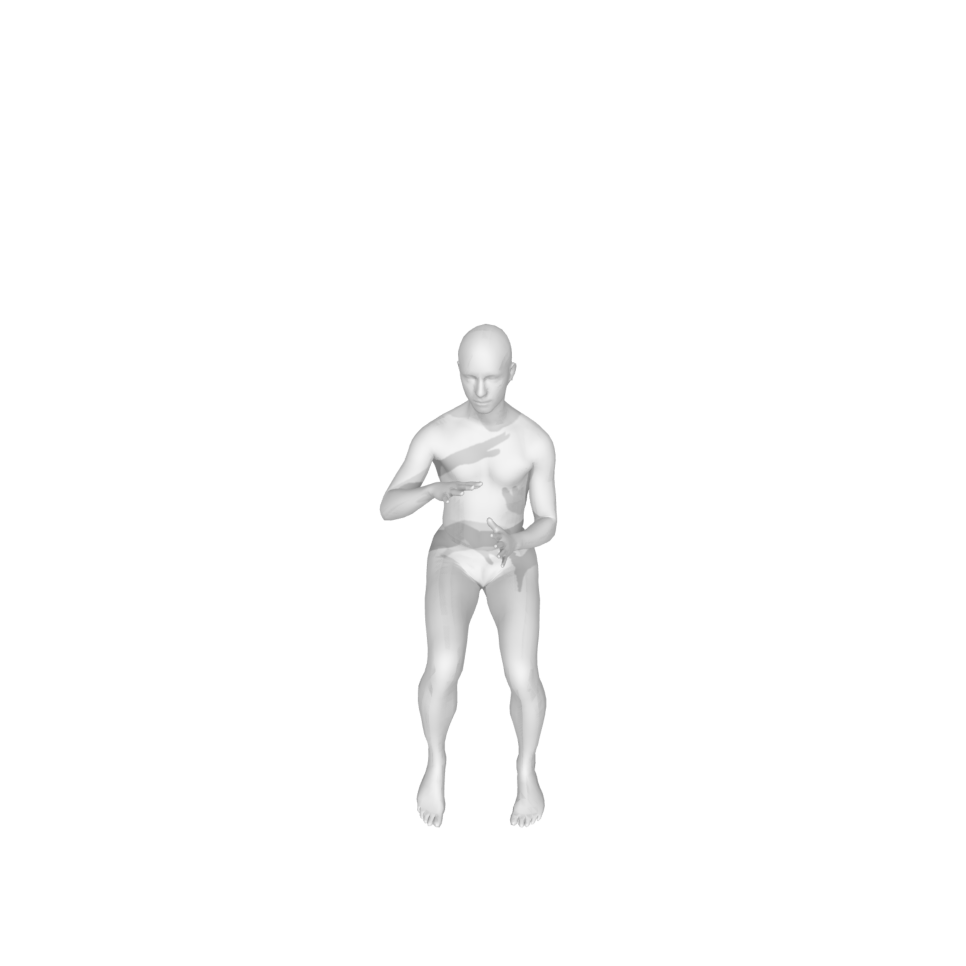

In [8]:
body = bm(pose_body=pose_body, betas=betas)
body_mesh = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
mv.set_static_meshes([body_mesh])
body_image = mv.render(render_wireframe=False)
show_image(body_image)

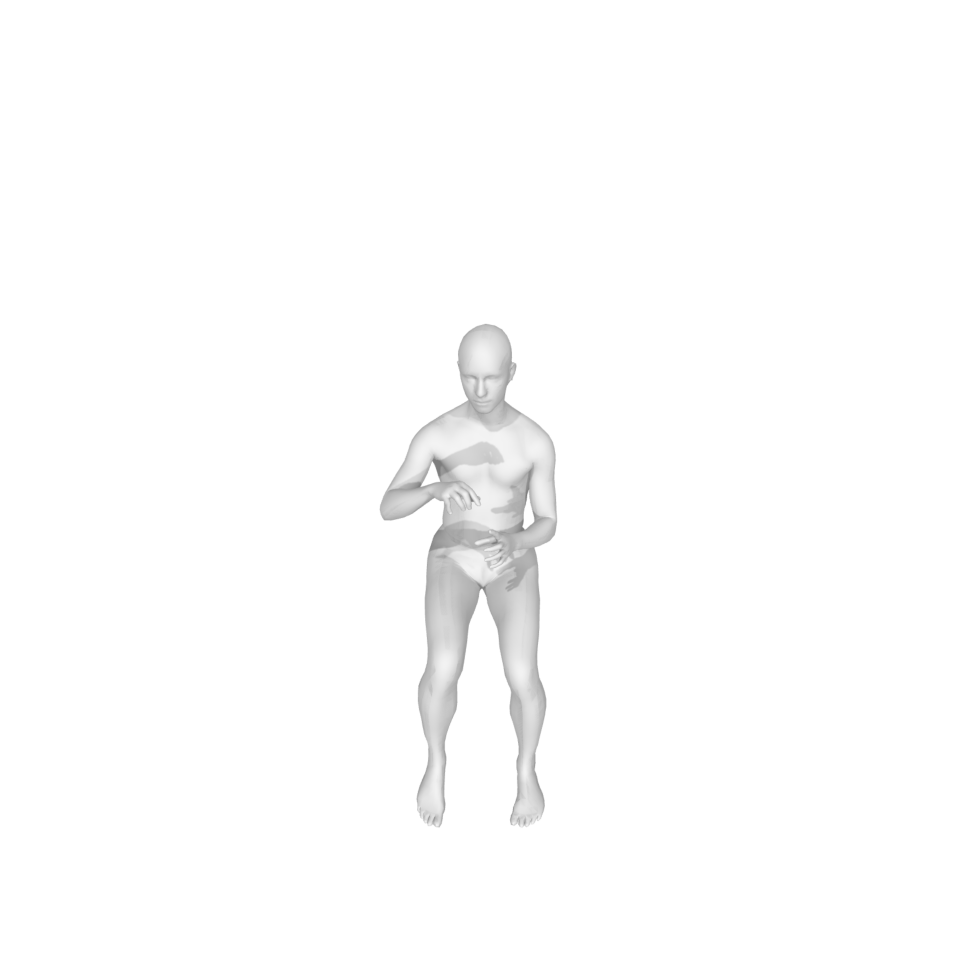

In [9]:
body = bm(pose_body=pose_body, pose_hand = pose_hand, betas=betas)
body_mesh_wfingers = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
mv.set_static_meshes([body_mesh_wfingers])
body_image_wfingers = mv.render(render_wireframe=False)
show_image(body_image_wfingers)

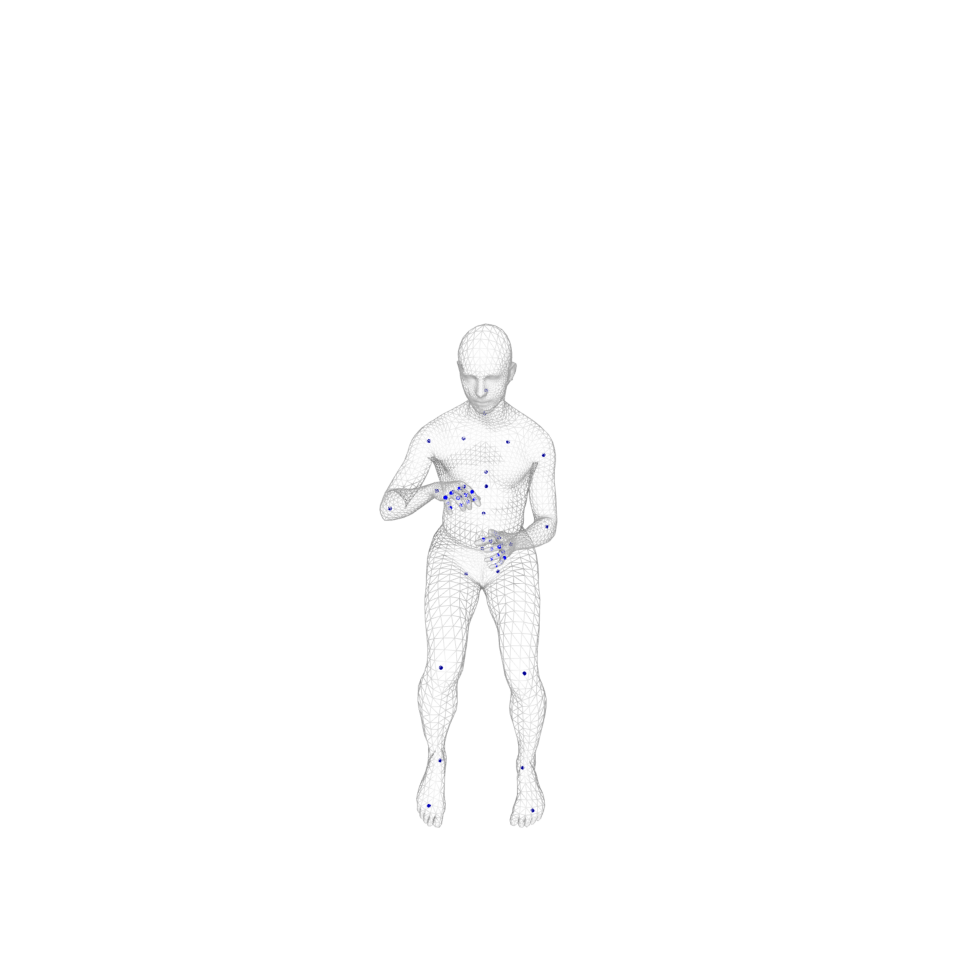

In [10]:
body = bm(pose_body=pose_body, pose_hand = pose_hand, betas=betas)
joints = c2c(body.Jtr[0])
joints_mesh = points_to_spheres(joints, vc = colors['red'], radius=0.005)
mv.set_static_meshes([body_mesh_wfingers] + joints_mesh)
body_image_wfingers_joints = mv.render(render_wireframe=True)
show_image(body_image_wfingers_joints)

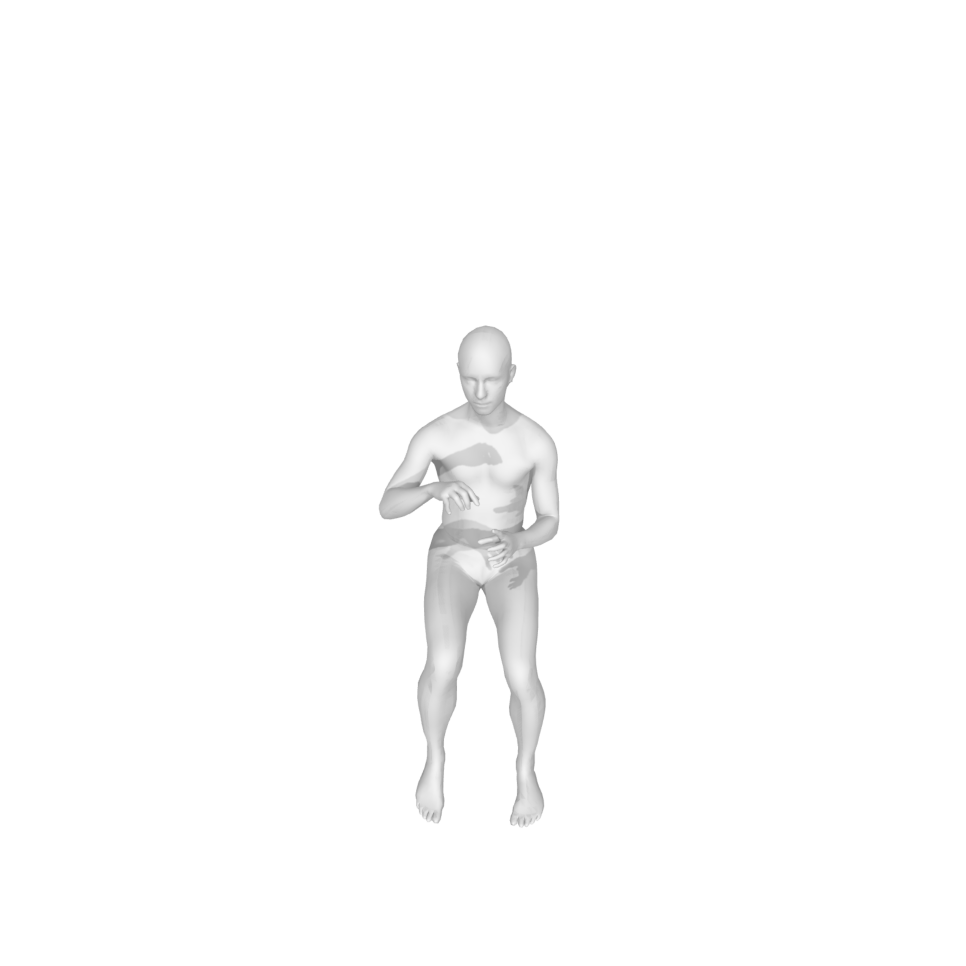

In [11]:
body = bm(pose_body=pose_body, pose_hand = pose_hand, betas=betas, dmpls=dmpls)
body_mesh_wdmpls = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
mv.set_static_meshes([body_mesh_wdmpls])
body_image_wdmpls = mv.render(render_wireframe=False)
show_image(body_image_wdmpls)

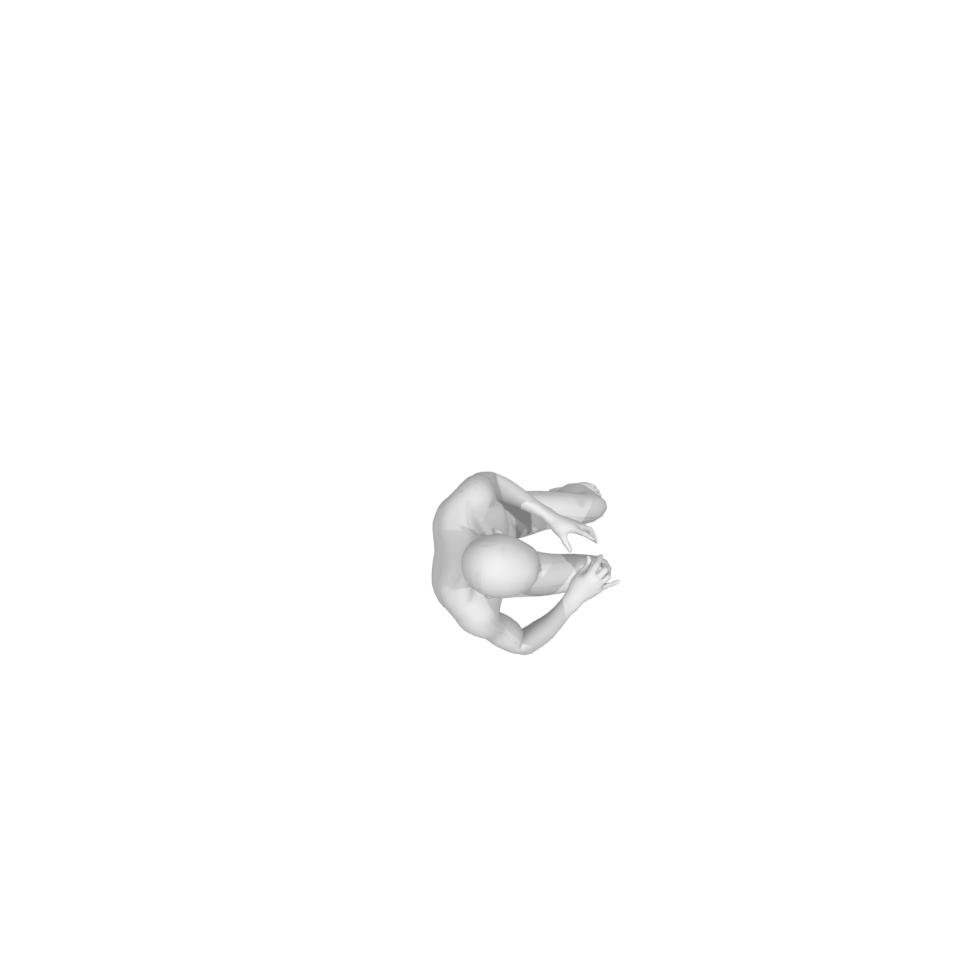

In [12]:
body = bm(pose_body=pose_body, pose_hand = pose_hand, betas=betas, dmpls=dmpls, root_orient=root_orient)
body_mesh_wrorient = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
mv.set_static_meshes([body_mesh_wrorient])
body_image_wrorient = mv.render(render_wireframe=False)
show_image(body_image_wrorient)

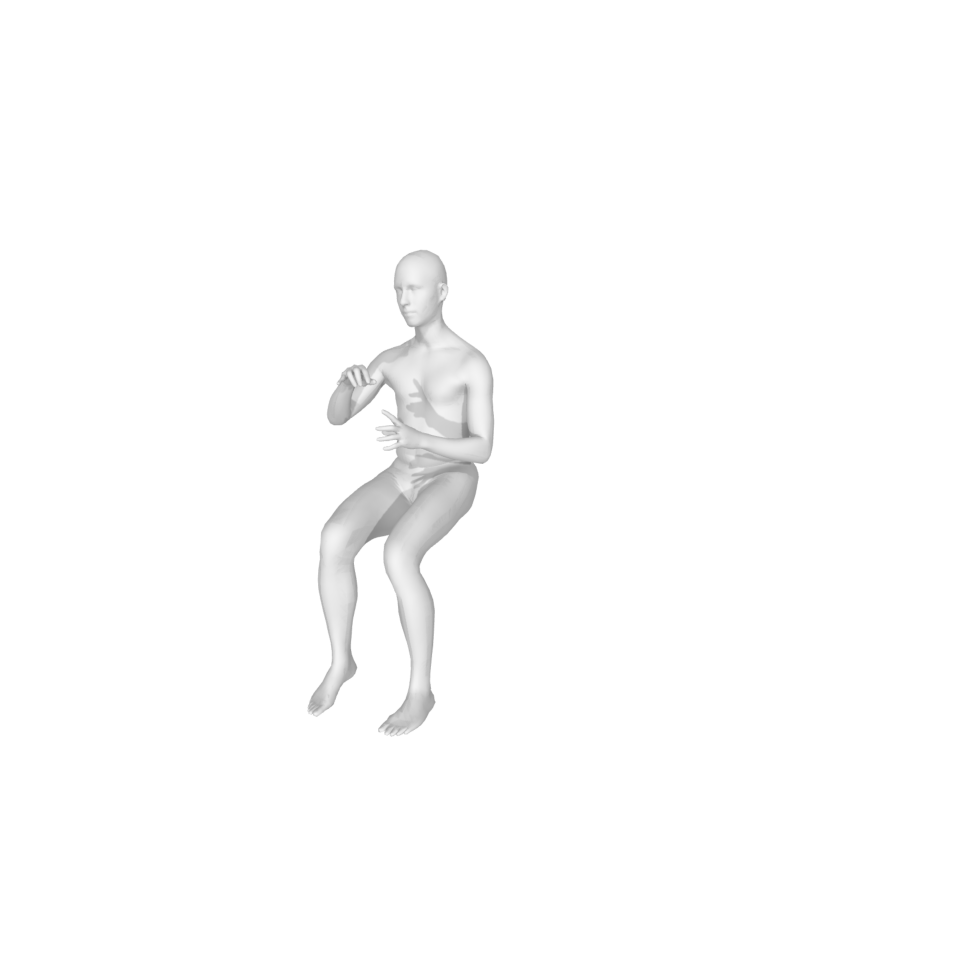

In [13]:
from human_body_prior.tools.omni_tools import apply_mesh_tranfsormations_
body = bm(pose_body=pose_body, pose_hand = pose_hand, betas=betas, dmpls=dmpls, root_orient=root_orient)
body_mesh_wrorient = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (6890, 1)))
apply_mesh_tranfsormations_([body_mesh_wrorient], trimesh.transformations.rotation_matrix(-90, (0, 0, 1)))
apply_mesh_tranfsormations_([body_mesh_wrorient], trimesh.transformations.rotation_matrix(30, (1, 0, 0)))

mv.set_static_meshes([body_mesh_wrorient])
body_image_wrorient = mv.render(render_wireframe=False)
show_image(body_image_wrorient)

In [ ]:
#